# Выбор локации для скважины

По условиям задачи, мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищем месторождения, для каждого определяем значения признаков;
- Строим модель и оцениваем объём запасов;
- Выбираем месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.


Условия задачи:
 - Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

В каждом датафрейме есть пять колонок:
- id — уникальный идентификатор скважины.
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы).
- product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

### Импорты и настройки

In [1]:
from collections import Counter
import re
import warnings

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import RandomState
import pandas as pd
import seaborn as sns
import scipy.stats as st
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Сделаем удобные настройки вывода

# Зададим формат отображения вещественных чисел в Pandas
pd.set_option('display.float_format', '{:,.2f}'.format)

# Не показываем предупреждение
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

# Зададим константу для генератора псевдослучайных чисел
RANDOM_STATE = 12345

# Зададим значение для генератора псевдослучайных чисел
np.random.seed(RANDOM_STATE)
STATE = RandomState(RANDOM_STATE)

### Загрузка датафрейма

In [3]:
try:
    df_1 = pd.read_csv('/datasets/gold_industry_train.csv')
except:
    df_1 = pd.read_csv('geo_data_0.csv')

try:
    df_2 = pd.read_csv('/datasets/geo_data_1.csv')
except:
    df_2 = pd.read_csv('geo_data_1.csv')

try:
    df_3 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    df_3 = pd.read_csv('geo_data_2.csv')

# Сохраним название датафреймов в переменную
dataframes_names = ['df_1', 'df_2', 'df_3']

### Обзор данных

Изучим структуру данных, выведем общую информацию.

In [4]:
# напишем функцию, которая принимает метод, который нам надо использовать
# и выводит результат применения этого метода ко всем датафреймам

def all_df(method, par=None):
    for df in dataframes_names:
        print('_______________________________________\n')
        print(f'Датафрейм {df}')
        display(getattr(eval(df), method)(par))

all_df('info')

_______________________________________

Датафрейм df_1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

_______________________________________

Датафрейм df_2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

_______________________________________

Датафрейм df_3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [5]:
# Выведем случайные пять строк каждой таблицы
all_df('sample', 5)

_______________________________________

Датафрейм df_1


,id,f0,f1,f2,product
71751,7Z2gx,0.95,-0.06,2.10,10.04
80493,b2HU8,0.99,0.21,-0.14,114.55
2655,Y0dXD,1.20,-0.56,-1.85,132.60
53233,Mje59,0.69,-0.43,0.56,169.07
91141,yqXxU,0.42,0.97,0.74,122.33


_______________________________________

Датафрейм df_2


,id,f0,f1,f2,product
70156,ElrxD,8.03,0.14,1.99,53.91
42796,zgfBu,-6.03,-3.12,2.99,84.04
36723,SkOBP,-6.18,-7.24,0.01,3.18
79446,xNTXq,19.40,-9.45,1.00,26.95
93328,MBKBZ,-11.33,-10.72,4.00,110.99


_______________________________________

Датафрейм df_3


,id,f0,f1,f2,product
2239,27k9G,0.07,0.05,5.55,52.61
40967,BXc4A,1.10,2.41,-1.95,52.27
86415,u56DZ,0.98,0.34,-1.90,71.34
59788,bITk7,3.62,5.32,5.24,162.94
37765,TEUoB,-2.14,0.28,2.49,155.37


In [6]:
# Напишем функцию для вывода основных статистик набораа данных

def dataframe_information(data):
    """Функция для вывода основных статистик набора данных"""
    df_data = []
    df_cols = ['name', 'object', 'na', 'zero', 'rate', 'unique', 'neg',
               'mean', 'std', 'min', 'max', 'outliners', 'duplicates']
    # перебираем столбцы в наборе данных
    for column_name in data.columns:
        column_negative_values, column_mean, column_std, column_min, column_max, outliers, duplicates_sum = \
            None, None, None, None, None, None, None
        # считаем характеристики
        column_type = data[column_name].dtypes
        column_na_values = data[column_name].isna().sum()
        column_zero_values = data[column_name][data[column_name] == 0].count()
        column_na_zero_rate = ((column_na_values + column_zero_values) / data.shape[0]) * 100
        column_unique_values = len(data[column_name].unique())
        duplicates_sum = len(data.loc[data.duplicated() > 0, column_name])
        if data[column_name].dtype != 'object':
            column_negative_values = data[column_name][data[column_name] < 0].count()
            column_mean = data[column_name].mean()
            column_std = data[column_name].std()
            column_min = data[column_name].min()
            column_max = data[column_name].max()
            q1 = data[column_name].quantile(0.25)
            q3 = data[column_name].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            outliers = len(data[(data[column_name] < lower_bound) | (data[column_name] > upper_bound)])

        # собираем показатели по каждому полю
        df_data.append([column_name, column_type, column_na_values,
                        column_zero_values, column_na_zero_rate, column_unique_values,
                        column_negative_values, column_mean, column_std,
                        column_min, column_max, outliers, duplicates_sum])

    # формируем набор данных
    df_res = pd.DataFrame(data=df_data, columns=df_cols)

    return df_res


# Применим функцию на датафреймы
for df in dataframes_names:
    print(f'_____________________________________________________________________________\nДатафрейм {df}:')
    display(dataframe_information(eval(df)))

_____________________________________________________________________________
Датафрейм df_1:


,name,object,na,zero,rate,unique,neg,mean,std,min,max,outliners,duplicates
0,id,object,0,0,0.00,99990,NaN,NaN,NaN,NaN,NaN,NaN,0
1,f0,float64,0,0,0.00,100000,"27,998.00",0.50,0.87,-1.41,2.36,0.00,0
2,f1,float64,0,0,0.00,100000,"34,379.00",0.25,0.50,-0.85,1.34,0.00,0
3,f2,float64,0,0,0.00,100000,"22,432.00",2.50,3.25,-12.09,16.00,506.00,0
4,product,float64,0,1,0.00,100000,0.00,92.50,44.29,0.00,185.36,0.00,0


_____________________________________________________________________________
Датафрейм df_2:


,name,object,na,zero,rate,unique,neg,mean,std,min,max,outliners,duplicates
0,id,object,0,0,0.00,99996,NaN,NaN,NaN,NaN,NaN,NaN,0
1,f0,float64,0,0,0.00,100000,"46,970.00",1.14,8.97,-31.61,29.42,1.00,0
2,f1,float64,0,0,0.00,100000,"82,531.00",-4.80,5.12,-26.36,18.73,636.00,0
3,f2,float64,0,0,0.00,100000,"8,317.00",2.49,1.70,-0.02,5.02,0.00,0
4,product,float64,0,8235,8.24,12,0.00,68.83,45.94,0.00,137.95,0.00,0


_____________________________________________________________________________
Датафрейм df_3:


,name,object,na,zero,rate,unique,neg,mean,std,min,max,outliners,duplicates
0,id,object,0,0,0.00,99996,NaN,NaN,NaN,NaN,NaN,NaN,0
1,f0,float64,0,0,0.00,100000,"49,777.00",0.00,1.73,-8.76,7.24,733.00,0
2,f1,float64,0,0,0.00,100000,"50,213.00",-0.00,1.73,-7.08,7.84,684.00,0
3,f2,float64,0,0,0.00,100000,"23,800.00",2.50,3.47,-11.97,16.74,584.00,0
4,product,float64,0,1,0.00,100000,0.00,95.00,44.75,0.00,190.03,0.00,0


Выявленные особенности данных:
1. В каждом датафрейме в колонке id уникальных значений меньше, чем количество строк. Так как это уникальный идеинтификатор скважены, такая ситуация выглядит странно, но так как данные синтетические, а данную колонку перед обучением модели мы все равно удалим, оставим данные без изменений. 
2. В третьем датафрейме в колонках f0, f1, f3 по ~6-7% выбросов, в других датафреймах также есть выбросы примерно в таком же обьеме, но только в одной из этих колонок. Так как мы не знаем что измеряют значения в этих колонках, судить о выбросах мы не можем.
3. Также в колонке product в первом и третьем датафрейме есть по одному случаю месторождений с нулевым запасом нефти, во втором датафрейме таких случаев очень много - 8.24% от всего датафрейма, видимо регион имеет малые запасы нефти, это вижно также по масимуму и среднему - они ниже, чем в остальных двух регионах. 
4. Во втором датафрейме всего 12 уникальных значений в колонке product, в то время как в остальных датафреймах уникальных значений столько же, сколько и строк в таблице. Посмотрим на эти уникальные значения. 

In [7]:
df_2['product'].value_counts(normalize=True).reset_index().sort_values('index')

,index,product
9,0.00,0.08
4,3.18,0.08
1,26.95,0.08
6,30.13,0.08
0,53.91,0.08
3,57.09,0.08
5,80.86,0.08
2,84.04,0.08
11,107.81,0.08
8,110.99,0.08


Посмотрим на распределение данных в целевой колонке во всех датафреймах.

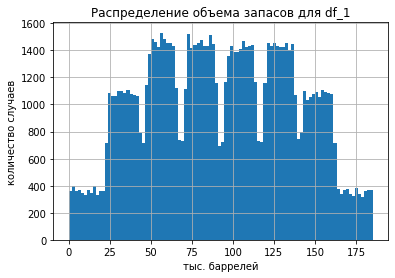

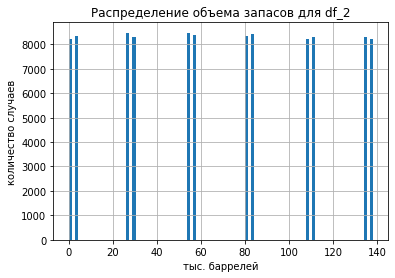

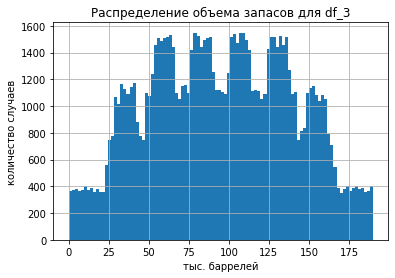

In [8]:
for df in dataframes_names:
    eval(df)['product'].hist(bins=100)
    plt.title(f'Распределение объема запасов для {df}')
    plt.xlabel('тыс. баррелей')
    plt.ylabel('количество случаев')
    plt.show()

Значения во втором датафрейме распределены равномерно. Данные синтетические, поэтому в данной ситуации с этой особенностью мы ничего делать не будем, она предоставлена нам для обучения.

Поскольку мы будем использовать линейную модель, нам важно не столкнуться с проблемой мультиколлинеарности. Посмотрим на корреляцию колонок между собой.

In [9]:
# Для обзора данных апишем функцию для нахождения пар колонок с максимальной корреляцией
def get_columns_with_max_correlation(data) -> list[dict[str: int]]:
    max_corr_list = []
    # чтобы не было ошибки, ограничим нужные колонки только числовыми
    columns = data.select_dtypes(include='number').columns
    for indx in range(len(columns)):
        correlation_temp = ['', 0]
        for indx2 in range(len(columns)):
            if columns[indx] != columns[indx2]:
                correlation = data[columns[indx]].corr(data[columns[indx2]])
                if correlation_temp[1] < abs(correlation):
                    correlation_temp = [columns[indx2], correlation]
        max_corr_list.append({columns[indx]: correlation_temp})
    return max_corr_list


# Выведем на экран общий список, где ключ словаря колонка, для которой ищем наиболее коррелирующую.
# Значение словаря - список из наиболее коррелирубщей колонки и размера корреляции.
for df in dataframes_names:
    display(get_columns_with_max_correlation(eval(df)))

[{'f0': ['product', 0.14353635093189274]},
 {'f1': ['product', -0.19235576281513284]},
 {'f2': ['product', 0.4836632869261524]},
 {'product': ['f2', 0.48366328692615246]}]

[{'f0': ['f1', 0.18228653311373366]},
 {'f1': ['f0', 0.18228653311373366]},
 {'f2': ['product', 0.9993969704906555]},
 {'product': ['f2', 0.9993969704906553]}]

[{'f0': ['product', -0.001987061999049139]},
 {'f1': ['product', -0.0010123938161309028]},
 {'f2': ['product', 0.4458710915574209]},
 {'product': ['f2', 0.44587109155742094]}]

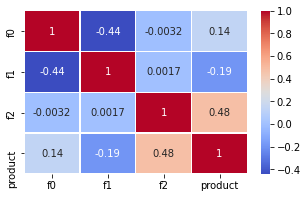

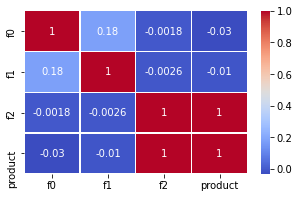

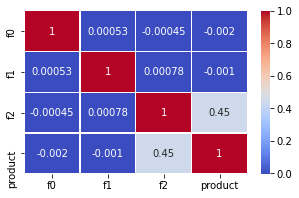

In [10]:
for df in dataframes_names:
    plt.figure(figsize=(5, 3))
    sns.heatmap(eval(df).corr(), cmap='coolwarm',  annot=True, linewidths=.2, robust=True)
    plt.show()

Колонка f2 во второй таблице имеет почти полную линейную связь с целевой колонкой. В других таблицах связь так же довольно сильна (0.48 и 0.45 уровень), это может быть признаком утечки данных, жаль мы не имеем возможности узнать, что измеряет признак f2. \
Также в первой таблице есть довольно высокая корреляция между признаками f1 и f2, она недостаточно сильная для риска мультиколлинеарности, но тоже весьма интересна. Во второй таблице также есть слабая связь между этими колонками, а в третьей таблице эта связь отсутствует. 

### Удалим лишние признаки

In [11]:
df_1 = df_1.drop('id', axis=1)
df_2 = df_2.drop('id', axis=1)
df_3 = df_3.drop('id', axis=1)

# проверим корректность удаления
all_df('info')

_______________________________________

Датафрейм df_1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


None

_______________________________________

Датафрейм df_2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


None

_______________________________________

Датафрейм df_3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


None

### Вывод:

Для обучения модели нам предоставлено три датафрейма с синтетическими данными, в каждом по 100 тысяч случаев и пять признаков. Колонка с id скважины имеет строковый тип данных, остальные колонки имеют вещественный тип. 

Так как id скважины не несет ценной информации для обучения модели, данную колонку мы удалили.

Данные имеют некоторые особенности, такие как: небольшое количество дублей в id скважены, выбросы, довольно много нулей и мало уникальных значений в колонке product во втором датафрейме. Но так как это синтетические данные, предоставленные нам для обучения, с этими особенностями мы ничего делать не стали. 

Мы измерили корреляцию признаков и выяснили, что признак f2 во второй таблице имеет почти полную линейную связь с целевой колонкой. В других таблицах связь так же довольно сильна (0.48 и 0.45 уровень), это может быть признаком утечки данных, жаль мы не имеем возможности узнать, что измеряет признак f2. \
Также в первой таблице есть довольно высокая корреляция между колонками f1 и f2 (0.44 уровень), она недостаточно сильна для риска мультиколлинеарности, но тоже интересная особенность данных. Во второй таблице также есть слабая связь между этими колонками, а в третьей же таблице эта связь полностью отсутствует. 

## Обучение и проверка модели

Целевой признак у нас product. Напишем функцию, которая принимает датафрейм и возвращает предсказания и правильные ответы на валидационной выборке. \
Так как признаки у нас имеют один масштаб, стандартизировать мы их не будем.

In [12]:
# Присвоим имена регионам
df_1.name, df_2.name, df_3.name = '№1', '№2', '№3'
res = {}

def split_and_standardization(df, df_name):
    # Разделим датафрейм на обучающую и валидационную выборки
    target = df['product']
    features = df.drop('product', axis=1)
    target_train, target_valid, features_train, features_valid = train_test_split(
    target, features, test_size=0.25, random_state=RANDOM_STATE
    )
    
    # Обучим модель, сохраним предсказания на валидационной выборке и RMSE
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = mean_squared_error(target_valid, predictions_valid) ** 0.5
    # Добавим результаты в словарь
    res[df_name] = [predictions_valid, list(target_valid)]
    # выведем предсказания и правильные ответы
    return (
        print(f'Cредний запас предсказанного сырья в регионе {df.name} - {predictions_valid.mean()}\n'
              f'Реальный средний запас сырья в регионе {df.name} - {target_valid.mean()}\n'
              f'RMSE модели - {result}\n')
    )

for df in dataframes_names:
    split_and_standardization(eval(df), df)

Cредний запас предсказанного сырья в регионе №1 - 92.59256778438035
Реальный средний запас сырья в регионе №1 - 92.07859674082927
RMSE модели - 37.5794217150813

Cредний запас предсказанного сырья в регионе №2 - 68.728546895446
Реальный средний запас сырья в регионе №2 - 68.72313602435997
RMSE модели - 0.893099286775617

Cредний запас предсказанного сырья в регионе №3 - 94.96504596800489
Реальный средний запас сырья в регионе №3 - 94.88423280885438
RMSE модели - 40.02970873393434



### Вывод

Мы разделили данные на обучающую и валидационную выборки, обучили модель и оценили точность предсказаний. \
Самые точные предсказания модель сделала для второго региона, но этот регион имеет самый низкий запас сырья. Думаю такой хороший результат получился из-за того, что колонка product во втором датафрейме имеет меньший диапазон возможных значений, они распределены очень равномерно, системно, поэтому наша модель хорошо уловила закономерность, а также из-за малого количества вариантов ответа, отклонение возможных значений гораздо меньше. 

## Подготовка к расчёту прибыли

Нам известны следующие факты:
```
1. При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
2. Бюджет на разработку скважин в регионе — 10 млрд рублей.
3. При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
4. После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
```

Запишем ключевые данные в переменные, они пригодятся нам для расчетов.

In [13]:
OIL_WELL = 500
BEST_OIL_WELL = 200
BUDGET = 10_000_000_000
REVENUE = 450000

Посчитаем, какой объем сырья достаточен для безубыточной разработки новой скважины.

In [14]:
print(f'Для безубыточной разработки новой скважины необходимо, \n'
      f'чтобы с нее вырабатывали не менее чем {(BUDGET/BEST_OIL_WELL)/REVENUE:.1f} тыс. баррелей.')

Для безубыточной разработки новой скважины необходимо, 
чтобы с нее вырабатывали не менее чем 111.1 тыс. баррелей.


In [15]:
for df in dataframes_names:
    best_oil_well = len([i for i in eval(df)['product'] if i > 111.1])
    perсent_best_oil_well = best_oil_well/len(eval(df))
    print(f'В регионе {eval(df).name} {perсent_best_oil_well * 100:.2f}% '
           'скважин имеют достаточный запас нефти.')
    print('При такой вероятности успеха, случайно получить 200 и более окупаемых скважин из 500 равна '
         f'{(1 - st.binom.cdf(BEST_OIL_WELL - 1, OIL_WELL, perсent_best_oil_well)) * 100:.2f} процентов.\n')

В регионе №1 36.59% скважин имеют достаточный запас нефти.
При такой вероятности успеха, случайно получить 200 и более окупаемых скважин из 500 равна 6.31 процентов.

В регионе №2 16.54% скважин имеют достаточный запас нефти.
При такой вероятности успеха, случайно получить 200 и более окупаемых скважин из 500 равна 0.00 процентов.

В регионе №3 38.19% скважин имеют достаточный запас нефти.
При такой вероятности успеха, случайно получить 200 и более окупаемых скважин из 500 равна 21.47 процентов.



In [16]:
# КОД РЕВЬЮЕРА
synth_df = pd.DataFrame({'target': np.random.uniform(high=1000, size=20000)})
synth_df['f2'] = synth_df.target.apply(
    lambda x: x+np.random.normal(scale=15.0)
)
synth_df.head()

,target,f2
0,588.78,587.99
1,615.29,632.71
2,920.90,940.32
3,108.45,120.42
4,987.08,994.03


In [17]:
synth_df.corr()

,target,f2
target,1.00,1.00
f2,1.00,1.00


In [18]:
train_df, test_df = train_test_split(synth_df, random_state=RANDOM_STATE)

In [19]:
pred = LinearRegression().fit(train_df[['f2']], train_df.target).predict(test_df[['f2']])
mean_squared_error(test_df.target, pred, squared=False)

14.70823084904085

### Вывод

Мы выяснили, что для безубыточной разработки новой скважины необходимо, чтобы из одной скважины вырабатывали не менее чем 111.1 тыс. баррелей. Учитывая, что средний обьем добычи в каждом регионе меньший чем нужный, нам необходимо чтобы модель выбирала лучшие скважины. \
В предоставленных нам датафреймах нужный объем имеют от 16 до 38 процентов скважин в каждом регионе. Учитывая, что разрабатывается 500 скважин и из них выбирается 200 лучших, вероятность случайно получить 200 и более окупаемых скважен из 500 - от 0% (во втором регионе), до 21% (в третьем). Хорошо, что много скважин, которые имеют бОльший, чем нужный нам запас, поэтому крайне важно, чтобы модель хорошо предсказывала лучшие скважины.

## Расчёт прибыли и рисков 

### Расчет прибыли

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели: выберем скважины с максимальным значением предсказаний, просумируем целевое значение обьема сырья соответствующее этим предсказаниям и расчитаем прибыль для полученного объема. \
Эта функция нам нужна для дальнейших расчетов, тество выведем прибыль по 200 лучшим скважинам (по предсказаним модели) во всех регионах.

In [20]:

def profit_calculation(predictions: list, target: list) -> int:
    predictions = pd.Series(predictions)
    target = pd.Series(target)
    top = predictions.sort_values(ascending=False)[:200]
    fact_sum_revenue = target[top.index].sum()



    # Код ревьюера
    if target[top.index].shape[0] != top.shape[0]:
        print("Shape mismatch!", target[top.index].shape)



    return fact_sum_revenue * REVENUE - BUDGET


for df_name in dataframes_names:
    predictions, target = res[df_name]
    print(f'Прибыль по 200 лучшим скважинам в регионе {eval(df_name).name} '
          f'{profit_calculation(predictions, target):.0f} рублей.')
    

Прибыль по 200 лучшим скважинам в регионе №1 3320826043 рублей.
Прибыль по 200 лучшим скважинам в регионе №2 2415086697 рублей.
Прибыль по 200 лучшим скважинам в регионе №3 2710349964 рублей.


### Расчет рисков

Посчитаем риски и прибыль для каждого региона. \
Смоделируем ситуацию, где мы выбираем 500 скважин в регионе, из них с помощью предсказаний модели выбираем 200 лучших. \
Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли, найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков для такого подхода. \
Предложим регион для разработки скважин.

_______________________________________________________________


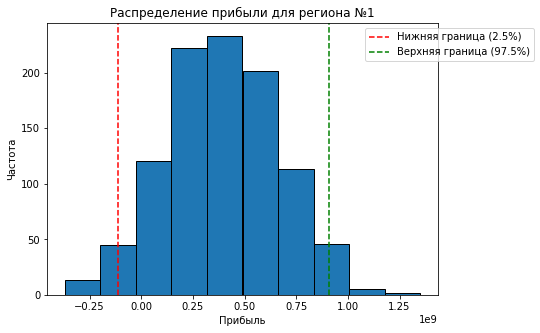

Средняя возможная прибыль в регионе №1 равна 396164985.
Возможная прибыль находится в диапазоне от -111215546 до 909766942.
Риск получить убыток составляет 6.90 процента.

_______________________________________________________________


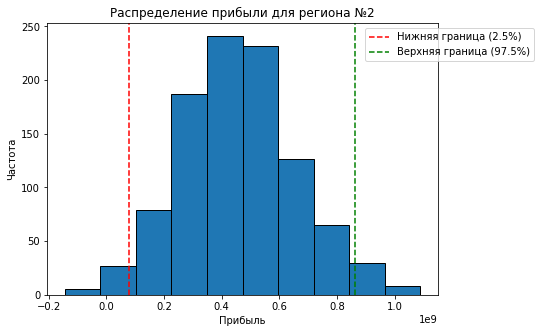

Средняя возможная прибыль в регионе №2 равна 461155817.
Возможная прибыль находится в диапазоне от 78050811 до 862952060.
Риск получить убыток составляет 0.70 процента.

_______________________________________________________________


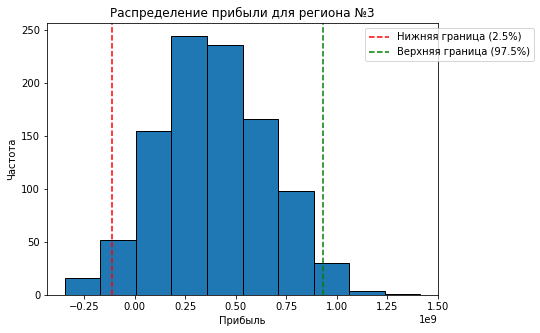

Средняя возможная прибыль в регионе №3 равна 392950475.
Возможная прибыль находится в диапазоне от -112227625 до 934562915.
Риск получить убыток составляет 6.50 процента.



In [23]:
def risk_calculation(predictions: list, target: list, df_name) -> str:
    profits = []
    predictions = pd.Series(predictions)
    target = pd.Series(target)
    # Сформируем выборку прибыли по 1000 семплам
    for i in range(1000):
        target_subsample = target.sample(OIL_WELL, replace=True, random_state=STATE)
        probs_subsample = predictions[target_subsample.index]
        profits.append(profit_calculation(list(probs_subsample), list(target_subsample)))
    # Найдем границы доверительного интервала
    profits = pd.Series(profits)
    low = profits.quantile(0.025)
    up = profits.quantile(0.975)
    # Получим риск убытка - найдем долю вариантов, в которых вместо прибыли мы получим убыток
    risk =len([i for i in profits if i < 0]) / len(profits) * 100
    # Визуализируем границы
    print('_______________________________________________________________')
    plt.figure(figsize=(7, 5))
    plt.hist(profits, bins=10, edgecolor='black')
    plt.axvline(x=low, color='red', linestyle='--', label='Нижняя граница (2.5%)')
    plt.axvline(x=up, color='green', linestyle='--', label='Верхняя граница (97.5%)')
    plt.xlabel('Прибыль')
    plt.ylabel('Частота')
    plt.title(f'Распределение прибыли для региона {eval(df_name).name}')
    plt.legend(bbox_to_anchor=(0.8, 1.00))
    plt.show()
    return (
        f'Средняя возможная прибыль в регионе {eval(df_name).name} равна {profits.mean():.0f}.\n'
        f'Возможная прибыль находится в диапазоне от {low:.0f} до {up:.0f}.\n'
        f'Риск получить убыток составляет {risk:.2f} процента.\n'
    )
    
    
for df_name in dataframes_names:
    predictions, target = res[df_name]
    print(risk_calculation(predictions, target, df_name))

Благодаря тому, что для второго региона наша модель хорошо предсказывает лучшие по запасам скважины, левая граница доверенного интервала находится выше нуля, в отличии от первого и третьего регионов где риск убытка намного выше. 

### Вывод 

Мы сделали функцию для расчета прибыли, посчитали возможную максимальную прибыль по всем регионам, она составила от 2.4 млрд. во втором регионе до 3.3 млрд в первом. \
Далее мы написали функцию для расчета рисков и выяснили:
```
Средняя возможная прибыль в регионе №1 равна 396164985.
Возможная прибыль находится в диапазоне от -111215546 до 909766942.
Риск получить убыток составляет 6.90 процента.

Средняя возможная прибыль в регионе №2 равна 461155817.
Возможная прибыль находится в диапазоне от 78050811 до 862952060.
Риск получить убыток составляет 0.70 процента.

Средняя возможная прибыль в регионе №3 равна 392950475.
Возможная прибыль находится в диапазоне от -112227625 до 934562915.
Риск получить убыток составляет 6.50 процента.
```

Благодаря тому, что для второго датасета наша модель хорошо предсказывает лучшие по запасам скважины, второй регион наиболее перспективен для разработки.